In [83]:
import time
import os
import subprocess
import sys
import re
import argparse
import collections
import gzip
import math
import shutil
import matplotlib.pyplot as plt
import wandb
import numpy as np
import time
from datetime import datetime
import random

import seaborn as sns
%matplotlib inline
import logging
from silence_tensorflow import silence_tensorflow
#silence_tensorflow()
os.environ['TPU_LOAD_LIBRARY']='0'
os.environ['TF_ENABLE_EAGER_CLIENT_STREAMING_ENQUEUE']='False'
import tensorflow as tf


import tensorflow.experimental.numpy as tnp
import tensorflow_addons as tfa
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision
from scipy.stats.stats import pearsonr  
from scipy.stats.stats import spearmanr  
## custom modules
import enformer_performer as enformer_performer
#import src.aformer_TF as aformer


import training_utils as training_utils


from scipy import stats



import kipoiseq
from kipoiseq import Interval
import pyfaidx
from deeplift import dinuc_shuffle

In [84]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='node-5')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE
    options.deterministic=False
    #options.experimental_threading.max_intra_op_parallelism = 1
    mixed_precision.set_global_policy('mixed_bfloat16')
    tf.config.optimizer.set_jit(True)
    #options.num_devices = 64

    BATCH_SIZE_PER_REPLICA = 1
    NUM_REPLICAS = strategy.num_replicas_in_sync
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * NUM_REPLICAS

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: node-5


INFO:tensorflow:Initializing the TPU system: node-5


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [85]:
with strategy.scope():
    heads_dict = {}
    orgs = ["hg"]
    for k, org in enumerate(orgs):
        heads_dict[org] = int(k)
        
        
    class Enformer:
        def __init__(self):

            #inits=training_utils.get_initializers("gs://picard-testing-176520/enformer_performer/models/enformer_performer_230214_E-P-_2696_enformer_393k_load_init-True_freeze-True_LR1-2.5e-06_LR2-8e-05_T-4_F-1536_K-relu_kernel_transformation/iteration_5")
            model = enformer_performer.enformer_performer( num_transformer_layers = 6,
                         num_heads= 8,
                         heads_channels = {'human': 2696,
                                                 'mouse': 987},
                         filter_list=[768,896,1024,1152,1280,1536],
                         dim=192,
                         d_model=1536,
                         norm=True,
                         max_seq_length=3072,
                         nb_random_features=256,
                         hidden_size=1536,
                         numerical_stabilizer=0.001,
                         attention_dropout_rate=0.05,
                         dropout_rate=0.40,
                         BN_momentum=0.90,
                         rel_pos_bins=3072,
                         out_length = 3072,
                         target_length = 896,
                         use_mask_pos=False,
                         use_rot_emb=True,
                         load_init=False,
                         freeze_conv_layers=False,
                         stable_variant=True,
                         inits=None,
                         kernel_transformation="relu_kernel_transformation",
                         normalize=True,
                         seed=5,
                         name='enformer_performer',
                         use_max_pool=False,
                         block_type='enformer')
            seq = tf.ones((1,393216,4))


            pred = model(seq,training=False)
            print('built model')
            model.load_weights("gs://picard-testing-176520/enformer_performer/models/enformer_performer_230214_E-P-_2696_enformer_393k_load_init-True_freeze-True_LR1-2.5e-06_LR2-8e-05_T-4_F-1536_K-relu_kernel_transformation/iteration_20/saved_model")
            self._model=model

        def predict_on_batch(self, inputs):
            return self._model.predict_on_batch(inputs)[0]

        @tf.function
        def contribution_input_grad(self, input_sequence,
                                    target_mask, track_index):
            input_sequence = input_sequence[tf.newaxis]

            target_mask_mass = tf.reduce_sum(target_mask)
            with tf.GradientTape() as tape:
                tape.watch(input_sequence)
                pred = self._model.predict_on_batch(input_sequence)[0]['human']#[:,:,track_index]

                prediction = tf.reduce_sum(
                      target_mask[tf.newaxis] * pred) / target_mask_mass

            grad = tape.gradient(prediction, input_sequence)
            input_grad = grad * input_sequence
            input_grad = tf.squeeze(input_grad, axis=0)

            return tf.reduce_sum(input_grad, axis=-1), grad
        
        
    # @title `variant_centered_sequences`
    #with strategy.scope():
    class FastaStringExtractor:

        def __init__(self, fasta_file):
            self.fasta = pyfaidx.Fasta(fasta_file)
            self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

        def extract(self, interval: Interval, **kwargs) -> str:
            # Truncate interval if it extends beyond the chromosome lengths.
            chromosome_length = self._chromosome_sizes[interval.chrom]
            trimmed_interval = Interval(interval.chrom,
                                        max(interval.start, 0),
                                        min(interval.end, chromosome_length),
                                        )
            # pyfaidx wants a 1-based interval
            sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                              trimmed_interval.start + 1,
                                              trimmed_interval.stop).seq).upper()
            # Fill truncated values with N's.
            pad_upstream = 'N' * max(-interval.start, 0)
            pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
            return pad_upstream + sequence + pad_downstream

        def close(self):
            return self.fasta.close()
        
        
    def one_hot_encode(sequence):
        return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


    def importance_scores(chrom, start, stop, target_index, mask_indices):

        target_interval = kipoiseq.Interval(chrom, int(start), int(stop))
        resized_interval = target_interval.resize(393216)
        sequence_one_hot = one_hot_encode(fasta_extractor.extract(resized_interval))
        #print(sequence_one_hot.shape)
        #print(sequence_one_hot[np.newaxis].shape)
        predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0,:,:]

        target_mask = np.zeros_like(predictions)
        for idx in mask_indices:
            target_mask[idx, target_index] = 1
            
        # This will take some time since tf.function needs to get compiled.
        contribution_scores, grad = model.contribution_input_grad(sequence_one_hot.astype(np.float32), target_mask, target_index)
        contribution_scores = contribution_scores.numpy()
        pooled_contribution_scores = tf.nn.avg_pool1d(np.abs(contribution_scores)[np.newaxis,
                                                                                  :, np.newaxis],
                                                      128, 128, 'VALID')[0, :, 0].numpy()

        base_scores = (sequence_one_hot[:][:].T * [contribution_scores[:],
                                                       contribution_scores[:],
                                                       contribution_scores[:],
                                                       contribution_scores[:]]).T

        gradient = np.multiply(sequence_one_hot[:][:].T, (np.squeeze(grad).T))
        ###### dinucleotide shuffled sequences
        seq_shuffled = dinuc_shuffle.dinuc_shuffle(sequence_one_hot, 1)[0]

        target_mask = np.zeros_like(predictions)
        for idx in mask_indices:
            target_mask[idx, target_index] = 1
        # This will take some time since tf.function needs to get compiled.

        contribution_scores_scram, grad_scram = model.contribution_input_grad(seq_shuffled, target_mask, target_index)
        contribution_scores_scram = contribution_scores_scram.numpy()
        pooled_contribution_scores_scram = tf.nn.avg_pool1d(np.abs(contribution_scores_scram)[np.newaxis,
                                                                                  :, np.newaxis],
                                                      128, 128, 'VALID')[0, :, 0].numpy()

        ## get base level matrix

        base_scores_scram = (seq_shuffled[:][:].T * [contribution_scores_scram[:],
                                            contribution_scores_scram[:],
                                            contribution_scores_scram[:],
                                            contribution_scores_scram[:]]).T

        ## get base level matri
        gradient_scram = np.multiply(seq_shuffled[:][:].T, (np.squeeze(grad_scram).T))



        return resized_interval,contribution_scores,pooled_contribution_scores,base_scores,np.squeeze(grad), sequence_one_hot,base_scores_scram, predictions

In [86]:
def write_out_bedgraph_pooled(pooled_contribution_scores, interval, filename_base):
    start = interval.start
    end =  interval.end
    chrom = interval.chrom
    name = '_'.join([str(chrom), str(start), str(end)])

    out_file = open(filename_base + '.pooled.bedGraph', 'w')


    for k, value in enumerate(pooled_contribution_scores):

        start_interval = k * 128 + start
        end_interval = (k+1) * 128 + start

        line = [str(chrom),
                str(start_interval), str(end_interval),
                str(value)]

        out_file.write('\t'.join(line) + '\n')
    out_file.close()
    
    
def write_out_bedgraph_all(contribution_scores, interval, filename_base):
    start = interval.start
    end =  interval.end
    chrom = interval.chrom
    name = '_'.join([str(chrom), str(start), str(end)])

    out_file = open(filename_base + '.all.bedGraph', 'w')


    for k, value in enumerate(contribution_scores):

        start_interval = start + k
        end_interval = start + k + 1

        line = [str(chrom),
                str(start_interval), str(end_interval),
                str(value)]

        out_file.write('\t'.join(line) + '\n')
    out_file.close()

In [87]:
## iterator
#with strategy.scope():
model = Enformer()
fasta_file = "/home/jupyter/reference/hg38.fa"
pyfaidx.Faidx(fasta_file)



built model


Faidx("/home/jupyter/reference/hg38.fa")

In [94]:


## center interval at the MYC promoter
chrom = "chr8"
start = 127736200
end = 127736285

#SEQUENCE_LENGTH=196608*2 # add 6 bp to allow for the +/- 0-3 bp shift
#target_length = 196608
fasta_extractor = FastaStringExtractor(fasta_file)

mask_indices=[446,447,448]
out = importance_scores("chr8", 127736151, 127736909,2494, mask_indices) # Jurkat resting corresponds to index 3
resized_int, scores, pooled, base_scores,grad, seq_one_hot,base_scores_shuff, predictions = out
write_out_bedgraph_pooled(pooled,
                          resized_int,
                          'k562_393k_test.pool.bedGraph')
write_out_bedgraph_all(np.abs(scores),
                          resized_int,
                          'k562_393k_test.bedGraph')

#np.save("Jurkat_resting.basescores.npy", np.array(base_scores))#, fmt='%10.8f')

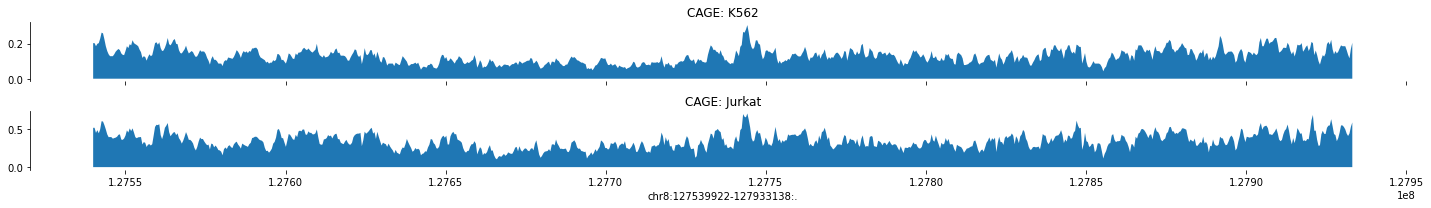

In [91]:
# K562: 2494
# jurkat: 2214

def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()
    
    
target_interval = kipoiseq.Interval("chr8", 127679186, 127793874)
    
    
tracks = {'CAGE: K562': np.log10(1.0+predictions[:, 2494]),
          'CAGE: Jurkat': np.log10(1.0+predictions[:, 2601])}
plot_tracks(tracks, resized_int)

In [95]:
resized_int

Interval(chrom='chr8', start=127539922, end=127933138, name='', strand='.', ...)

In [96]:
127854410 - 127539922

314488

In [74]:
chr8:127,854,355-127,854,410

Interval(chrom='chr8', start=127539922, end=127933138, name='', strand='.', ...)

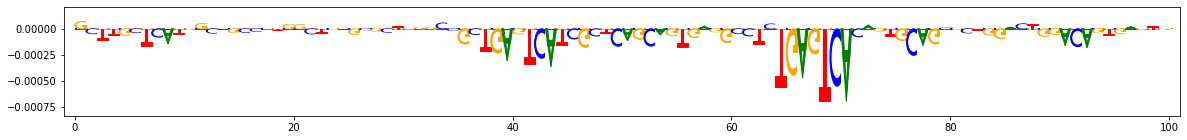

In [99]:
import modisco.visualization
from modisco.visualization import viz_sequence
fig = viz_sequence.plot_weights(base_scores[314408:314508,:], subticks_frequency=20)
fig.figure.savefig('k562.logplot.pdf')

In [58]:
388278 + 127539922

127928200

In [ ]:
TGAGTCA